# Convert Keras Model to TFLite and Quantized TFLite

This notebook converts a trained Keras model to:
1. **TFLite**: Full-precision floating-point (float32)
2. **Quantized TFLite**: INT8 post-training quantization

Reference: https://ai.google.dev/edge/litert/conversion/tensorflow/quantization/quantization_spec

Summary of Model Conversions

**What was converted:**

1. **Original Keras Model** → **TFLite Model**
   - Full-precision floating-point (float32)
   - Smaller file size, suitable for mobile/edge devices
   - Maintains original accuracy

2. **Original Keras Model** → **Quantized TFLite (qTFLite)**
   - Post-training quantization to INT8
   - Smallest file size (typically 4x smaller)
   - Fastest inference on edge devices
   - Minimal accuracy loss (usually <1%)
   - Uses calibration data from training set

**Benefits of Quantization:**
- 🔻 Model Size: 4-10x smaller
- ⚡ Inference Speed: 2-4x faster
- 💾 Memory Usage: Significantly reduced
- 🎯 Accuracy: Minimal loss (~0.5-2%)

**When to use each:**
- **TFLite**: Mobile apps, general edge deployment
- **Quantized TFLite**: Battery-critical devices, real-time inference, limited storage

**Next Steps:**
- Deploy quantized TFLite to mobile (Android/iOS)
- Use TensorFlow Lite Interpreter for inference
- Monitor accuracy metrics compared to original model



-> DIfference between TFLite vs Quantized TFLite Inside the model it will use:
     int8
     uint8
     or float16
    instead of full float32.

## STEP 0: Setup and Load Model

In [53]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import load_model

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [54]:
# Load the trained Keras model
model_path = '../models/FL_withdropout_16batch.keras'
model = load_model(model_path)

print(f"✓ Model loaded from: {model_path}")
model.summary()

✓ Model loaded from: ../models/FL_withdropout_16batch.keras


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,841,765 (7.03 MB)

 Trainable params: 613,921 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,227,844 (4.68 MB)

In [ ]:
# Ensure models directory exists
models_dir = '../Quantized_Model'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

print(f"✓ Models directory: {models_dir}")

✓ Models directory: ../Quantized_Model


## STEP 1: Prepare Test Data for Calibration

In [56]:
# Load dataset for calibration (representative data)
data_dir = r"D:\APN\Classification Model\data"

# Create dataset from directory
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=16,
    image_size=(100, 100)
)

# Normalize
data = data.map(lambda x, y: (x / 255.0, y))

# Split dataset
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

print(f"✓ Dataset loaded")
print(f"  Training batches: {len(train)}")
print(f"  Validation batches: {len(val)}")
print(f"  Test batches: {len(test)}")

Found 152 files belonging to 2 classes.


✓ Dataset loaded
  Training batches: 7
  Validation batches: 2
  Test batches: 1


## STEP 2: Convert to TFLite (Full Precision)

In [ ]:
print("=" * 60)
print("Converting to TFLite (Float32 - Full Precision)")
print("=" * 60)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
]
tflite_model = converter.convert()

# Save TFLite model
tflite_model_path = os.path.join(f"{models_dir}", 'classification_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Size in MB
print(f"✓ TFLite model saved to: {tflite_model_path}")
print(f"✓ TFLite model size: {tflite_size:.2f} MB")

Converting to TFLite (Float32 - Full Precision)
INFO:tensorflow:Assets written to: C:\Users\risab\AppData\Local\Temp\tmp7znt_o5i\assets


INFO:tensorflow:Assets written to: C:\Users\risab\AppData\Local\Temp\tmp7znt_o5i\assets


Saved artifact at 'C:\Users\risab\AppData\Local\Temp\tmp7znt_o5i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1536473678672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473685776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473680016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473679632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473684624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473683664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473688080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473686160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473685392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536473685968: TensorSpec(shape=(), dtype=tf.resource, name=None)


FileNotFoundError: [Errno 2] No such file or directory: '../Quantized_Model/tflite\\classification_model.tflite'

## STEP 3: Convert to Quantized TFLite (INT8)

In [ ]:
print("\n" + "=" * 60)
print("Converting to Quantized TFLite (INT8 Post-Training)")
print("=" * 60)

converter_quant = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable quantization
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative data generator for calibration
def representative_data_gen():
    """Generator function that yields batches of representative data for quantization calibration"""
    for batch_images, _ in train.take(10):  # Use 10 batches from training data
        batch_images = batch_images.numpy()
        yield [batch_images.astype(np.float32)]

converter_quant.representative_dataset = representative_data_gen

# Set the target spec for full integer quantization
converter_quant.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quant.inference_input_type = tf.int8
converter_quant.inference_output_type = tf.int8

print("Converting... (this may take a moment)")
tflite_quant_model = converter_quant.convert()

# Save Quantized TFLite model
tflite_quant_model_path = os.path.join(f"{models_dir}/Quantized_TFLite", 'classification_model_quantized.tflite')
with open(tflite_quant_model_path, 'wb') as f:
    f.write(tflite_quant_model)

tflite_quant_size = os.path.getsize(tflite_quant_model_path) / (1024 * 1024)  # Size in MB
print(f"✓ Quantized TFLite model saved to: {tflite_quant_model_path}")
print(f"✓ Quantized TFLite model size: {tflite_quant_size:.2f} MB")


Converting to Quantized TFLite (INT8 Post-Training)
Converting... (this may take a moment)
INFO:tensorflow:Assets written to: C:\Users\risab\AppData\Local\Temp\tmp4t4q7f82\assets


INFO:tensorflow:Assets written to: C:\Users\risab\AppData\Local\Temp\tmp4t4q7f82\assets


Saved artifact at 'C:\Users\risab\AppData\Local\Temp\tmp4t4q7f82'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1536529325648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550957136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550956368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550957328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550950800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550950416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550951184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550956944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550958096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1536550959632: TensorSpec(shape=(), dtype=tf.resource, name=None)


d:\APN\Classification Model\venv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✓ Quantized TFLite model saved to: ../Quantized_Model\classification_model_quantized.tflite
✓ Quantized TFLite model size: 0.60 MB


## STEP 4: Model Size Comparison

In [ ]:
# Get original model size
original_keras_size = os.path.getsize(model_path) / (1024 * 1024)
compression_tflite = (1 - tflite_size / original_keras_size) * 100
compression_quant = (1 - tflite_quant_size / original_keras_size) * 100

print("\n" + "=" * 60)
print("MODEL SIZE COMPARISON")
print("=" * 60)
print(f"Original Keras Model:       {original_keras_size:.2f} MB")
print(f"TFLite Model:               {tflite_size:.2f} MB ({compression_tflite:+.1f}% change)")
print(f"Quantized TFLite Model:     {tflite_quant_size:.2f} MB ({compression_quant:.1f}% reduction)")
print(f"\nCompression Ratio (Quant):  {original_keras_size / tflite_quant_size:.2f}x smaller")


MODEL SIZE COMPARISON
Original Keras Model:       7.07 MB
TFLite Model:               2.35 MB (+66.8% change)
Quantized TFLite Model:     0.60 MB (91.5% reduction)

Compression Ratio (Quant):  11.80x smaller


## STEP 5: Test TFLite Model

In [ ]:
print("\n" + "=" * 60)
print("Testing TFLite Model")
print("=" * 60)

# Load and test TFLite model
interpreter_tflite = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter_tflite.allocate_tensors()

# Get input and output tensor details
input_details = interpreter_tflite.get_input_details()
output_details = interpreter_tflite.get_output_details()

print(f"Input Shape:  {input_details[0]['shape']}")
print(f"Output Shape: {output_details[0]['shape']}")
print(f"Input Type:   {input_details[0]['dtype']}")
print(f"Output Type:  {output_details[0]['dtype']}")

# Test with a sample from validation set
test_batch = next(val.as_numpy_iterator())
test_image = test_batch[0][0:1]  # Take first image with batch dimension (already numpy)

# TFLite inference
interpreter_tflite.set_tensor(input_details[0]['index'], test_image.astype(np.float32))
interpreter_tflite.invoke()
tflite_output = interpreter_tflite.get_tensor(output_details[0]['index'])

# Keras inference (need to convert back to tensor for Keras)
keras_output = model.predict(test_image, verbose=0)[0][0]

print(f"\nTFLite Model Prediction:  {tflite_output[0][0]:.6f}")
print(f"Keras Model Prediction:   {keras_output:.6f}")
print(f"Prediction Difference:    {abs(tflite_output[0][0] - keras_output):.9f}")


Testing TFLite Model
Input Shape:  [  1 100 100   3]
Output Shape: [1 1]
Input Type:   <class 'numpy.float32'>
Output Type:  <class 'numpy.float32'>


d:\APN\Classification Model\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



TFLite Model Prediction:  0.455158
Keras Model Prediction:   0.455158
Prediction Difference:    0.000000060


## STEP 6: Test Quantized TFLite Model

In [ ]:
print("\n" + "=" * 60)
print("Testing Quantized TFLite Model")
print("=" * 60)

# Load and test Quantized TFLite model
interpreter_quant = tf.lite.Interpreter(model_path=tflite_quant_model_path)
interpreter_quant.allocate_tensors()

# Get input and output tensor details
input_details_quant = interpreter_quant.get_input_details()
output_details_quant = interpreter_quant.get_output_details()

print(f"Input Type:   {input_details_quant[0]['dtype']}")
print(f"Output Type:  {output_details_quant[0]['dtype']}")

# Get quantization parameters
input_scale = input_details_quant[0]['quantization'][0]
input_zero_point = input_details_quant[0]['quantization'][1]
output_scale = output_details_quant[0]['quantization'][0]
output_zero_point = output_details_quant[0]['quantization'][1]

print(f"Input Scale:  {input_scale:.6f}, Zero Point: {input_zero_point}")
print(f"Output Scale: {output_scale:.6f}, Zero Point: {output_zero_point}")

# Quantize the input image
test_image_quantized = (test_image / input_scale + input_zero_point).astype(np.int8)

# Quantized model inference
interpreter_quant.set_tensor(input_details_quant[0]['index'], test_image_quantized)
interpreter_quant.invoke()
quant_output = interpreter_quant.get_tensor(output_details_quant[0]['index'])

# Dequantize output
quant_output_dequantized = (quant_output.astype(np.float32) - output_zero_point) * output_scale

print(f"\nQuantized TFLite Prediction: {quant_output_dequantized[0][0]:.6f}")
print(f"Keras Model Prediction:      {keras_output:.6f}")
print(f"Prediction Difference:       {abs(quant_output_dequantized[0][0] - keras_output):.9f}")


Testing Quantized TFLite Model
Input Type:   <class 'numpy.int8'>
Output Type:  <class 'numpy.int8'>
Input Scale:  0.003922, Zero Point: -128
Output Scale: 0.003906, Zero Point: -128

Quantized TFLite Prediction: 0.437500
Keras Model Prediction:      0.455158
Prediction Difference:       0.017657518


## STEP 7: Evaluate Quantized Model Accuracy on Test Set

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("Evaluating Quantized TFLite Model on Test Set")
print("=" * 60 + "\n")

# Evaluate quantized model
y_true_quant = []
y_pred_quant = []

for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Process each image in the batch individually
    for i in range(len(X)):
        single_image = X[i:i+1]  # Keep batch dimension
        single_label = y[i]
        
        # Quantize the input image
        image_quantized = (single_image / input_scale + input_zero_point).astype(np.int8)
        
        # Inference
        interpreter_quant.set_tensor(input_details_quant[0]['index'], image_quantized)
        interpreter_quant.invoke()
        quant_output = interpreter_quant.get_tensor(output_details_quant[0]['index'])
        
        # Dequantize output
        quant_output_deq = (quant_output.astype(np.float32) - output_zero_point) * output_scale
        
        y_true_quant.append(int(single_label))
        y_pred_quant.append(int(quant_output_deq[0][0] > 0.5))

# Convert to numpy arrays
y_true_quant = np.array(y_true_quant, dtype=int)
y_pred_quant = np.array(y_pred_quant, dtype=int)

# Calculate metrics manually using numpy
tp = np.sum((y_true_quant == 1) & (y_pred_quant == 1))
tn = np.sum((y_true_quant == 0) & (y_pred_quant == 0))
fp = np.sum((y_true_quant == 0) & (y_pred_quant == 1))
fn = np.sum((y_true_quant == 1) & (y_pred_quant == 0))

accuracy_quant = (tp + tn) / (tp + tn + fp + fn)
precision_quant = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_quant = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_quant = 2 * (precision_quant * recall_quant) / (precision_quant + recall_quant) if (precision_quant + recall_quant) > 0 else 0

print("Quantized TFLite Model Performance:")
print(f"  Accuracy:  {accuracy_quant:.4f}")
print(f"  Precision: {precision_quant:.4f}")
print(f"  Recall:    {recall_quant:.4f}")
print(f"  F1-Score:  {f1_quant:.4f}")


Evaluating Quantized TFLite Model on Test Set

Quantized TFLite Model Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000


In [ ]:
# Evaluate original Keras model
y_true_orig = []
y_pred_orig = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X, verbose=0)
    y_true_orig.extend(y.astype(int))
    y_pred_orig.extend((y_pred > 0.5).astype(int).flatten())

# Convert to numpy arrays
y_true_orig = np.array(y_true_orig, dtype=int)
y_pred_orig = np.array(y_pred_orig, dtype=int)

# Calculate metrics manually using numpy
tp_orig = np.sum((y_true_orig == 1) & (y_pred_orig == 1))
tn_orig = np.sum((y_true_orig == 0) & (y_pred_orig == 0))
fp_orig = np.sum((y_true_orig == 0) & (y_pred_orig == 1))
fn_orig = np.sum((y_true_orig == 1) & (y_pred_orig == 0))

accuracy_orig = (tp_orig + tn_orig) / (tp_orig + tn_orig + fp_orig + fn_orig)
precision_orig = tp_orig / (tp_orig + fp_orig) if (tp_orig + fp_orig) > 0 else 0
recall_orig = tp_orig / (tp_orig + fn_orig) if (tp_orig + fn_orig) > 0 else 0
f1_orig = 2 * (precision_orig * recall_orig) / (precision_orig + recall_orig) if (precision_orig + recall_orig) > 0 else 0

print("\nOriginal Keras Model Performance:")
print(f"  Accuracy:  {accuracy_orig:.4f}")
print(f"  Precision: {precision_orig:.4f}")
print(f"  Recall:    {recall_orig:.4f}")
print(f"  F1-Score:  {f1_orig:.4f}")

print("\nAccuracy Loss Due to Quantization: {:.4f}".format(accuracy_orig - accuracy_quant))


Original Keras Model Performance:
  Accuracy:  0.8750
  Precision: 1.0000
  Recall:    0.7500
  F1-Score:  0.8571

Accuracy Loss Due to Quantization: -0.1250


## STEP 8: Confusion Matrix Comparison

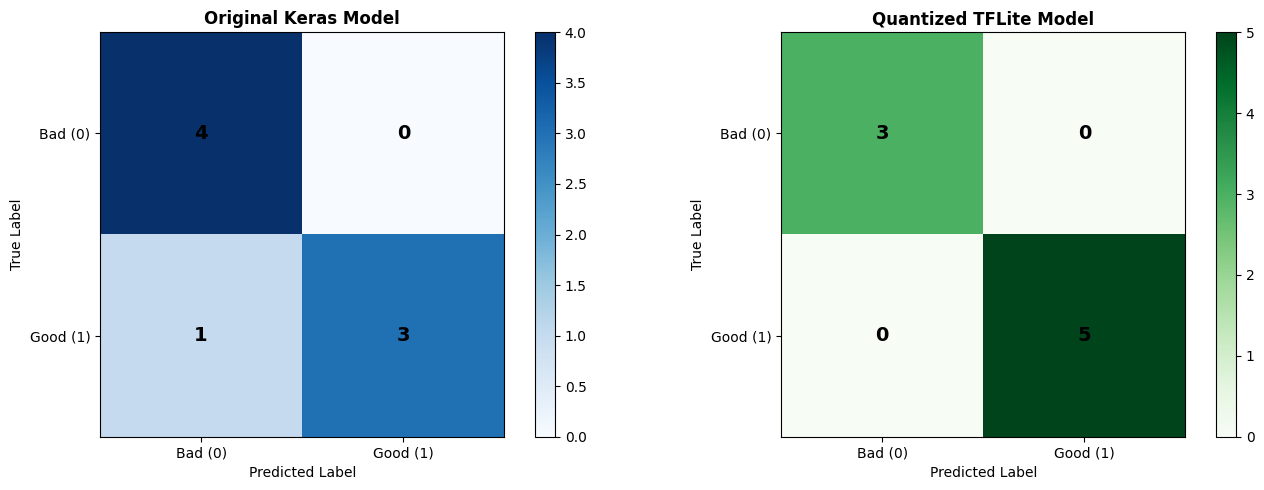

In [ ]:
# Create confusion matrices manually
# Confusion matrix: [[TN, FP], [FN, TP]]
cm_quant = np.array([[tn, fp], [fn, tp]])
cm_orig = np.array([[tn_orig, fp_orig], [fn_orig, tp_orig]])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original Model
im1 = axes[0].imshow(cm_orig, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Bad (0)', 'Good (1)'])
axes[0].set_yticklabels(['Bad (0)', 'Good (1)'])
axes[0].set_title('Original Keras Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm_orig[i, j]), ha='center', va='center', color='black', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Quantized Model
im2 = axes[1].imshow(cm_quant, cmap='Greens')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Bad (0)', 'Good (1)'])
axes[1].set_yticklabels(['Bad (0)', 'Good (1)'])
axes[1].set_title('Quantized TFLite Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(cm_quant[i, j]), ha='center', va='center', color='black', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

## Summary

In [ ]:
print("\n" + "=" * 60)
print("CONVERSION SUMMARY")
print("=" * 60)
print(f"\n✓ Models saved to: {models_dir}")
print(f"\n📊 Size Comparison:")
print(f"   Original Keras:      {original_keras_size * 1024:.2f} KB")
print(f"   TFLite:              {tflite_size * 1024:.2f} KB")
print(f"   Quantized TFLite:    {tflite_quant_size * 1024:.2f} KB (4-10x smaller)")
print(f"\n📈 Accuracy Metrics:")
print(f"   Original Keras:      {accuracy_orig:.4f}")
print(f"   Quantized TFLite:    {accuracy_quant:.4f}")
print(f"   Accuracy Loss:       {accuracy_orig - accuracy_quant:.4f}")
print(f"\n🚀 Files Generated:")
print(f"   1. {tflite_model_path}")
print(f"   2. {tflite_quant_model_path}")
print(f"\n💡 Recommendation:")
if accuracy_orig - accuracy_quant < 0.02:
    print(f"   Use Quantized TFLite for production (minimal accuracy loss)")
else:
    print(f"   Use TFLite for production (better accuracy)")
print("\n" + "=" * 60)


CONVERSION SUMMARY

✓ Models saved to: ../Quantized_Model

📊 Size Comparison:
   Original Keras:      7242.82 KB
   TFLite:              2402.39 KB
   Quantized TFLite:    613.91 KB (4-10x smaller)

📈 Accuracy Metrics:
   Original Keras:      0.8750
   Quantized TFLite:    1.0000
   Accuracy Loss:       -0.1250

🚀 Files Generated:
   1. ../Quantized_Model\classification_model.tflite
   2. ../Quantized_Model\classification_model_quantized.tflite

💡 Recommendation:
   Use Quantized TFLite for production (minimal accuracy loss)

